# 1. Linear Regression

Let's fabricate some data that shows a roughly linear relationship between average vehicle speed, and bumpiness of the road. In the real world, LIDAR data might be used on a self-driving car to measure the road conditions, and the vehicle might need to adjust its speed accordingly.

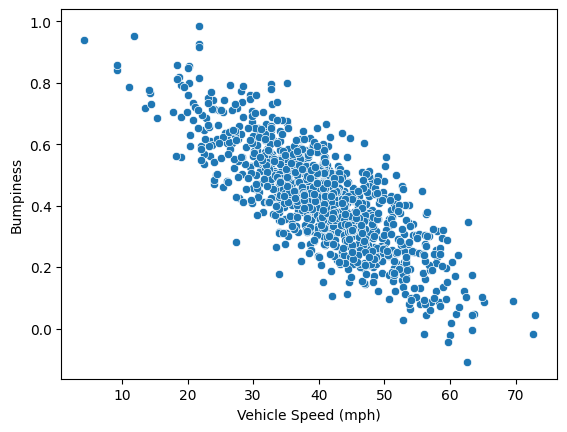

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data for vehicle speeds and bumpiness
vehicleSpeeds = np.random.normal(40.0, 10.0, 1000)
bumpiness = (1.0 - (vehicleSpeeds / 70.0)) + np.random.normal(0, 0.1, 1000)

# Create a scatterplot using Seaborn
sns.scatterplot(x=vehicleSpeeds, y=bumpiness)

# Set labels for the axes
plt.xlabel("Vehicle Speed (mph)")
plt.ylabel("Bumpiness")

# Show the plot
plt.show()

As we only have two features, we can keep it simple and just use scipy.state.linregress:

In [4]:
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(vehicleSpeeds, bumpiness)


Not surprisngly, our R-squared value shows a decent fit:

In [5]:
r_value ** 2 #(Shows the variance in the dataset)

0.6429908241487712

Let's use the slope and intercept we got from the regression to plot predicted values vs. observed:

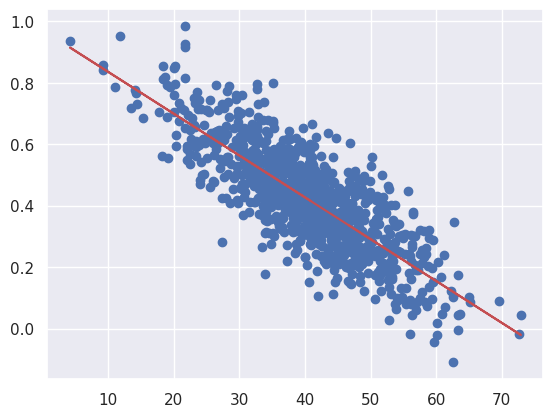

In [6]:
def predict(x):
    return slope * x + intercept

sns.set()

fitLine = predict(vehicleSpeeds)

plt.scatter(vehicleSpeeds, bumpiness)
plt.plot(vehicleSpeeds, fitLine, c='r')
plt.show()

#2. Logistic Regression
Logistic regression is like linear regression, but for classification problems. It still produces a line, but the line is used to separate data between two categories of some sort, which requires a slightly different approach internally.

To illustrate logistic regression in a relevant example, let's fabricate some data that illustrates two categories of vehicles speeds: "slow" and "fast". And, we'll plot each point against two axes, one representing the distance to an upcoming bump in the road, and the other the size of the bump. In theory, cars should slow down when approaching a large bump, and slow down more the closer you get to it. This behavior could perhaps be learned from data from real drivers approaching real bumps.

We don't have a real dataset for this, but we can fabricate one. We'll use scikit-learn's "make_blobs" function to create a couple of clusters of each category ("fast" and "slow") near the corners of our graph:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs

n_samples = 10000

# To generate our fabricated data set, we'll create two blobs of
# randomly distributed data at two corners of the graph...
centers = [(0.9, 0.05), (0.05, 0.94)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=0.4,
                  centers=centers, shuffle=False, random_state=42)

# Then filter out only the values that lie within [0,1]:
features = []
labels = []
for feature, label in zip(X, y):
    if (feature[0] >= 0 and feature[0] <= 1.0 and feature[1] >= 0 and feature[1] <= 1.0):
        features.append(feature)
        labels.append(label)

# And convert the results back into numpy arrays:
X = np.array(features)
y = np.array(labels)

<ipython-input-8-da6f3478dd9b>:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(this_X[:, 0], this_X[:, 1], c=color,


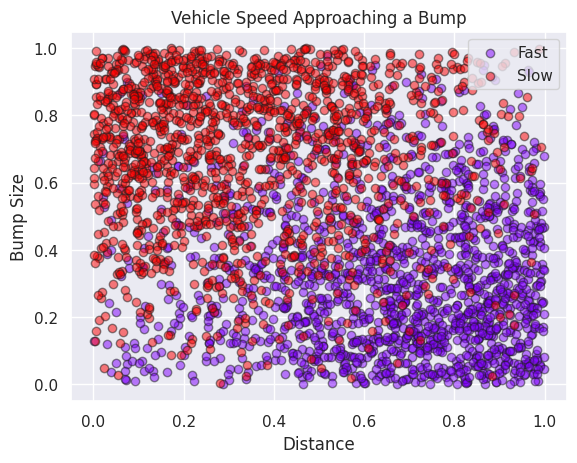

In [8]:
# Let's visualize our fabricated data set:

plt.figure()
y_unique = np.unique(y)
class_names = ['Fast', 'Slow']
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X[y == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], c=color,
                alpha=0.5, edgecolor='k',
                label=class_names[this_y])
plt.legend(loc="best")
plt.xlabel('Distance')
plt.ylabel('Bump Size')
plt.title("Vehicle Speed Approaching a Bump")
plt.show()

Creating a logistic regression model in scikit-learn is easy-peasy. There are several hyperparameters you can set on it, but most often the regularization term "C" is what people tinker with. It's default is 1.0, which we'll leave as-is for this simple problem.

After creating the classification model, we fit it to our data, which causes the model to learn the correct line for splitting the data as training data is fed into it.

In [9]:
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C=1.0)

logreg.fit(X, y)

LogisticRegression()

Let's visualize our results, by using our model to plot the predicted classification values for every point on the grid's mesh. We'll also visualize the training data over it, so we can see how well the predictions match the data.

<ipython-input-10-cf042447ff77>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))


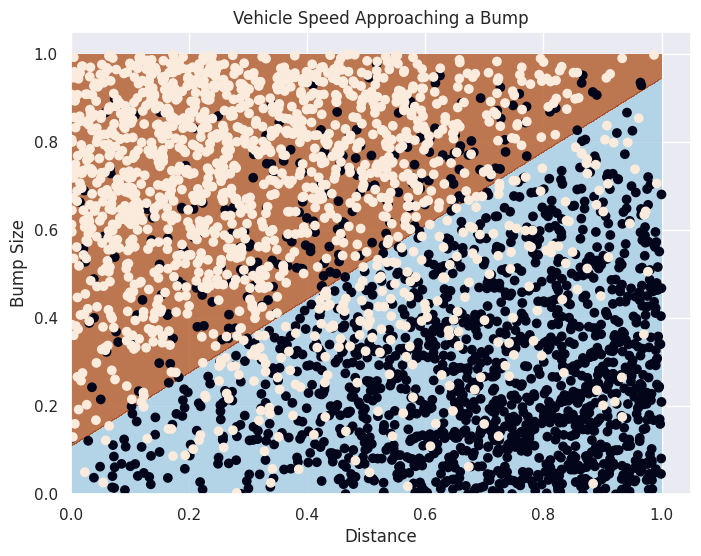

In [10]:
def plotPredictions(clf):
    xx, yy = np.meshgrid(np.arange(0, 1.0, 0.001),
                     np.arange(0, 1.0, 0.001))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(8, 6))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))
    plt.xlabel('Distance')
    plt.ylabel('Bump Size')
    plt.title("Vehicle Speed Approaching a Bump")
    plt.show()

plotPredictions(logreg)

Rather than just eyeballing the results, we can use train/test to quantify how well our model predicts classifications of "slow" or "fast" speeds based on bump size and distance. Scikit-learn has a handy train_test_split function we can use to randomly divide our data set into training data and testing data. So, we'll train (fit) our logistic regression model using only the training data, then call score() on it to measure its accuracy in predicting labels in the test data that it hasn't seen before.

The resulting score is just the mean accuracy of the predictions. So we see that on average, we predict correctly about 84% of the time. Remember this number, as we'll try different models on this same data set as we go through the course.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.840983606557377

To ensure we're not overfitting to one specific train/test split, we can do k-fold cross validation instead. Scikit-learn also makes this easy; its cross_val_score function can run cross validation on any machine learning model for any number of folds. Here, we'll do 5-fold cross validation, and cross_val_score will automatically split up the data set for us, for each fold.

It returns the mean accuracy for each fold, and we can boil that down to a single metric by just taking the mean score from all the folds.

In [12]:
from sklearn.model_selection import cross_val_score

fold_scores = cross_val_score(logreg, X, y, cv=5)
print (fold_scores)
print (np.mean(fold_scores))

[0.86885246 0.84098361 0.8407225  0.82758621 0.83415435]
0.8424598239521925


# 3. Support Vector Machines

Let's stick with our example of classifying vehicle speeds based on the size of a bump, and our distance to it:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs

n_samples = 10000

# To generate our fabricated data set, we'll create two blobs of
# randomly distributed data at two corners of the graph...
centers = [(0.9, 0.05), (0.05, 0.94)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=0.4,
                  centers=centers, shuffle=False, random_state=42)

# Then filter out only the values that lie within [0,1]:
features = []
labels = []
for feature, label in zip(X, y):
    if (feature[0] >= 0 and feature[0] <= 1.0 and feature[1] >= 0 and feature[1] <= 1.0):
        features.append(feature)
        labels.append(label)

# And convert the results back into numpy arrays:
X = np.array(features)
y = np.array(labels)

<ipython-input-15-aa3d464261c4>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))


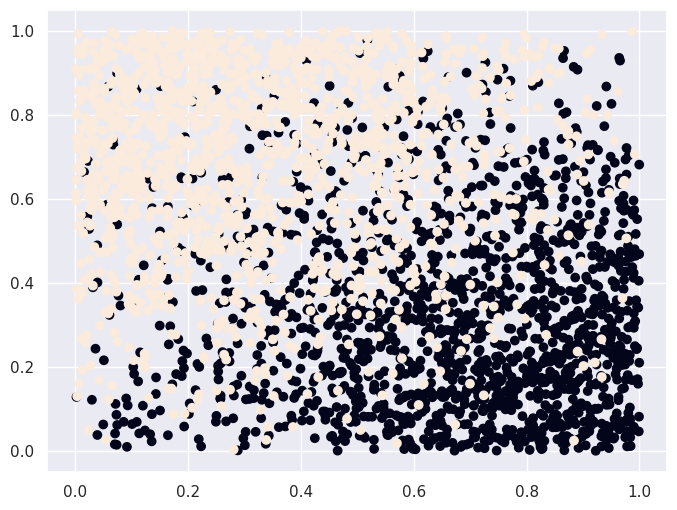

In [15]:
%matplotlib inline
from pylab import *

plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))
plt.show()

Now we'll use linear SVC to partition our graph into clusters:

In [16]:
from sklearn import svm, datasets

C = 1.0
svc = svm.SVC(kernel='linear', C=1.0).fit(X, y)

By setting up a dense mesh of points in the grid and classifying all of them, we can render the regions of each cluster as distinct colors:

<ipython-input-17-d1ca33b4b215>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))


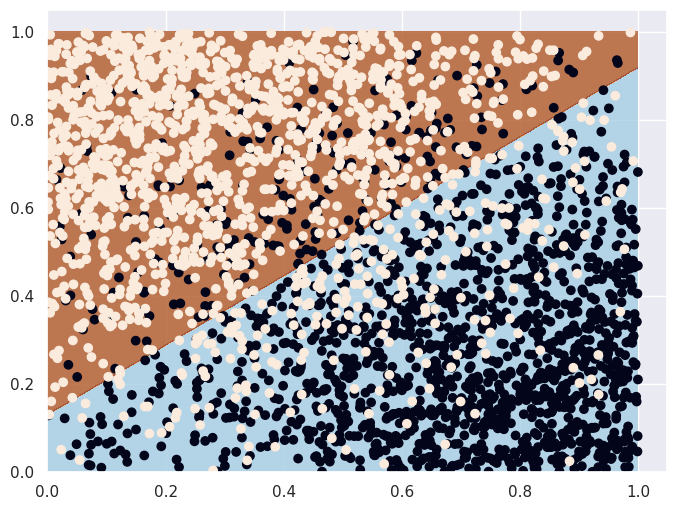

In [17]:
def plotPredictions(clf):
    xx, yy = np.meshgrid(np.arange(0, 1.0, 0.001),
                     np.arange(0, 1.0, 0.001))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(8, 6))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))
    plt.show()

plotPredictions(svc)

Or just use predict for a given point:

In [18]:
print(svc.predict([[0.3, 0.3]]))

[0]


In [19]:
print(svc.predict([[0, 1]]))

[1]


In [20]:
from sklearn.model_selection import cross_val_score

fold_scores = cross_val_score(svc, X, y, cv=5)
print (fold_scores)
print (np.mean(fold_scores))

[0.86721311 0.83934426 0.8407225  0.83087028 0.83415435]
0.8424609006971924


## Hyperparameter tuning and RBF
We warned the RBF kernel, although very powerful, is prone to over-fitting if gamma is set too high. Let's explore whether RBF is an appropriate kernel for our simple data set, and if so, what sort of gamma value makes sense.

Let's start by assuming RBF can handle this without breaking a sweat, and just try and find the best gamma value. We'll use GridSearchCV, which is an easy way of doing k-fold cross validation over an array of different parameter values we want to try out. We call this process "hyperparameter tuning."

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

param_grid = dict(gamma=[0, 0.5, 1.0, 2.0, 3.0, 10.0, 100.0, 1000.0])
grid = GridSearchCV(svm.SVC(kernel='rbf'), param_grid=param_grid, cv=10)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'gamma': 0.5} with a score of 0.84


Hm, so we ended up with a very low gamma value working out best. What does it look like?

<ipython-input-17-d1ca33b4b215>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))


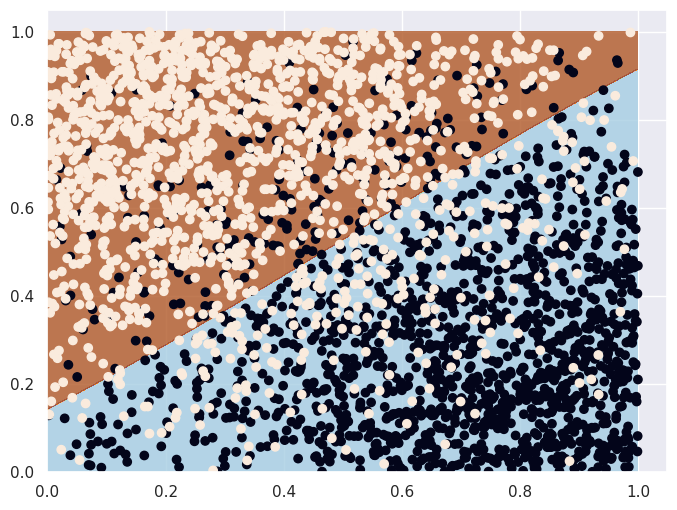

In [22]:
svc = svm.SVC(kernel='rbf', gamma=grid.best_params_['gamma']).fit(X, y)

plotPredictions(svc)

Well, that looks really close to a linear kernel. So, maybe RBF is overkill for this data set. Let's assume linear is the way to go, and just try to tune its hyperparameter of "C":

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

param_grid = dict(C=[0.1, 0.5, 1.0, 2.0, 3.0, 10.0, 100.0, 1000.0])
grid = GridSearchCV(svm.SVC(kernel='linear'), param_grid=param_grid, cv=10)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 0.5} with a score of 0.84


A low value of C works best, it seems. Let's see how it looks:

<ipython-input-17-d1ca33b4b215>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.scatter(X[:,0], X[:,1], c=y.astype(np.float))


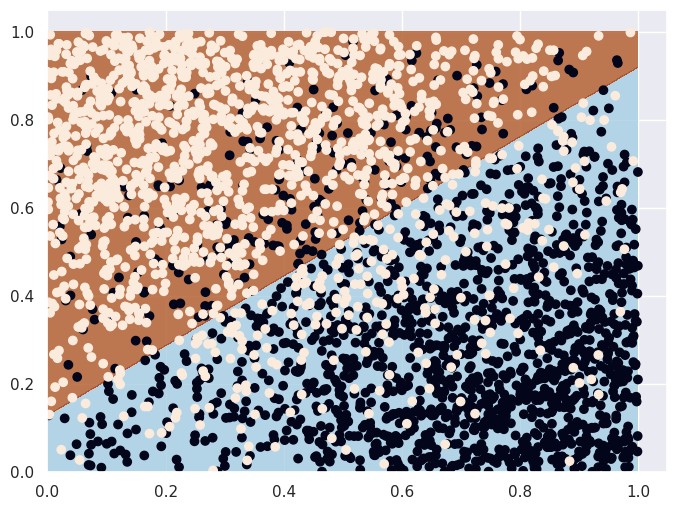

In [24]:
svc = svm.SVC(kernel='linear', C=grid.best_params_['C']).fit(X, y)

plotPredictions(svc)

Looks pretty much identical to the rbf kernel with a small gamma, but the model is much simpler - and given the choice between simple and complex, simple is always the right choice all things being equal.